In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [27]:
def plotvaluecounts(dfSource,_column):
    dfTemp=pd.DataFrame(round(dfSource[_column].value_counts(normalize=True)*100.0,2)).reset_index()
    dfTemp.columns=["column_values",'value_percentage']
    dfTemp.insert(0,"column_name",column_name)
    fig,ax1=plt.subplots(figsize=(5,5))
    sns.barplot(x='column_values',y='value_percentage',data=dfTemp,orient='h',ax=ax1)
    plt.show()

In [28]:
def checkColumnHasOutlier(dfInput,column_name,minQuartile=0.1,maxQuartile=0.9):
    QMin=dfInput[column_name].quantile(minQuartile)
    QMax=dfInput[column_name].quantile(maxQuartile)
    IQR=QMax-QMin
    IQRmin=QMin-(1.5*IQR)
    IQRmax=QMax+(1.5*IQR)
    dfLessThan=dfInput[dfInput[column_name]<IQRmin]
    dfGreaterThan=dfInput[dfInput[column_name]>IQRmax]
    hasOutlier=(dfLessThan.empty==False and dfGreaterThan.empty==False)
    return hasOutlier

In [29]:
def getNullColumns(dfInput, exporttocsv=False,filename='nullcolumns.csv'):
    null_count=dfInput.isnull().sum()
    null_percentage=100.0*dfInput.isnull().sum()/len(dfInput.index)
    dfFinal=pd.DataFrame({'column_name':dfInput.columns,'null_count':null_count,'null_percentage':null_percentage,'dtype':dfInput.dtypes}).reset_index()
    for idx,row in dfFinal.iterrows():
        column_name=row['column_name']
        data_type=row['dtype']
        if data_type in ['float64','int64']:
            dfFinal['HasOutlier']=checkColumnHasOutlier(dfInput,column_name)
        else:
            dfFinal['HasOutlier']='False'
    if exporttocsv==True:
        dfFinal.to_csv(filename,index=False)
    dfFinal=dfFinal.drop('column_name',axis=1)
    dfFinal=dfFinal.rename({'index':'column_name'},axis=1)
    dfFinal=dfFinal[dfFinal['null_percentage']>0]
    dfFinal=dfFinal.sort_values(by='null_count',ascending=False).reset_index(drop=True)
    return dfFinal

In [30]:
def getColumnsByType(dfInput,column_type,exclude=False):
    lstColumns=[]
    column_type=column_type.strip().lower()
    dft=pd.DataFrame(dfInput.dtypes).reset_index()
    dft.columns=['column_name','dtype']
    if column_type=='numeric':
        lstColumns=list(dft[(dft['dtype']=='float64')|(dft['dtype']=='int64')|(dft['dtype']=='bool')]['column_name'])
    elif column_type=='categorical':
        lstColumns=list(dft[dft['dtype']=='object']['column_name'])
    return lstColumns
        

In [31]:
def applyBinValue(row,group_column_name,column_name,i,_interval,_StopMaxValue=0):
    groupvalue=str(i)+"-"+str(i+_interval)
    if row[group_column_name]=='':
        if row[column_name]>=i and row[column_name]<=i+_interval:
            if _StopMaxValue==0 or (i+_interval)<=_StopMaxValue:
                return groupvalue
            else:
                if (i+_interval)> _StopMaxValue:
                    return 'Greater Than '+str(_StopMaxValue)
        else:
                return ''
    else:
        return row[group_column_name]

In [32]:
def createBinValues(dfSource,column_name,_interval,_StopMaxValue=0):
    dfSource[column_name]=dfSource[column_name].astype(int)
    group_name=column_name+"group"
    _min=dfSource[column_name].min()
    _max=dfSource[column_name].max()
    dfSource[group_name]=''
    for i in range(_min,_max,_interval):
        dfSource[group_name]=dfSource.apply(lambda x: applyBinValue(x,group_name,column_name,i,_interval,_StopMaxValue),axis=1)
    return dfSource[group_name].value_counts()


In [33]:
def drawHeatMapByPivot(dfSource,_indexColumn,_columns,_valueslist,aggfuncDictionary,drawHeatMap=True,_sort_values=False,_sortby=[],_figX=10,_figY=10):
    dfPivot=dfSource.pivot_table(index=_indexColumn,
    columns=_columns,
    values=_valueslist,
    aggfunc=aggfuncDictionary

    )
    if _sort_values==True:
        dfPivot=dfPivot.sort_values(by=_sortby,ascending=False)
    if drawHeatMap==True:
        plt.figure(figsize=(_figX,_figY))
        sns.heatmap(dfPivot,annot=True,cmap='Blues',fmt='g') 



In [34]:
def removeOutliersByThresholdValue(dfSource,column_name,threshold_value,draw_plot=False):
    dfTemp=dfSource[dfSource[column_name]<=threshold_value]
    if draw_plot==True:
        dfTemp.boxplot(column=[column_name],vert=False)
        plt.show()
    return dfTemp

In [35]:
dfSource=pd.read_csv('AB_NYC_2019.csv')
dfSource.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,19-10-2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,21-05-2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,05-07-2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,19-11-2018,0.10,1,0


<h2>Null Handling and Data Cleaning</h2>

In [36]:
getNullColumns(dfSource)

,column_name,null_count,null_percentage,dtype,HasOutlier
0,last_review,10052,20.558339,object,False
1,reviews_per_month,10052,20.558339,float64,False
2,host_name,21,0.042949,object,False
3,name,16,0.032723,object,False


In [37]:
#1.fill empty host_name with Host Id
#2.fill empty reviews_per_month with 0
#3.fill empty name with 'neighbourhood'+'room_type'+host_id
#4.Replace names with special Characters
dfSource['host_name'].fillna(value=dfSource['host_id'],inplace=True)
dfSource['reviews_per_month'].fillna(value=0,inplace=True)
dfSource['name'].fillna(value=dfSource['neighbourhood']+dfSource['room_type']+str(dfSource['host_id']),inplace=True)
dfSource['name'].replace({r'[^\x00-\x7F]+':''},regex=True,inplace=True)

In [38]:
getNullColumns(dfSource)

,column_name,null_count,null_percentage,dtype,HasOutlier
0,last_review,10052,20.558339,object,False


<h3>Change Date Format properly and Derive Calculated Columns</h3>

In [39]:
dfSource['last_review']=dfSource['last_review'].str.replace('-','/')
dfSource['last_review_date']=pd.to_datetime(dfSource['last_review'])
dfSource['last_review_Year']=dfSource[~dfSource['last_review'].isnull()]['last_review_date'].dt.strftime('%Y')
dfSource['last_review_month']=dfSource[~dfSource['last_review'].isnull()]['last_review_date'].dt.strftime('%m')
dfSource['last_review_elapsed']=pd.Timestamp('today').floor('D')-dfSource['last_review_date']
dfSource['last_review_elapsed']=dfSource['last_review_elapsed'].astype(str)
dfSource['last_review_elapsed']=dfSource['last_review_elapsed'].str.replace('NaT','0 days')
dfSource['last_review_elapsed']=dfSource['last_review_elapsed'].str.replace(' days','')
dfSource['last_review_elapsed']=dfSource['last_review_elapsed'].astype(float)
dfSource['last_review_elapsed'].fillna(0)
dfSource[['last_review_date','last_review_Year','last_review_month','last_review_elapsed']].head()







,last_review_date,last_review_Year,last_review_month,last_review_elapsed
0,2018-10-19,2018,10,2334.0
1,2019-05-21,2019,05,2120.0
2,NaT,NaN,NaN,0.0
3,2019-07-05,2019,07,2075.0
4,2018-11-19,2018,11,2303.0


<h3>Check for Outliers and Remove</h3>

In [40]:
getColumnsByType(dfSource,'numeric')

['id',
 'host_id',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'last_review_elapsed']

<h4>Check for Outlier: Price</h4>

KeyboardInterrupt: 

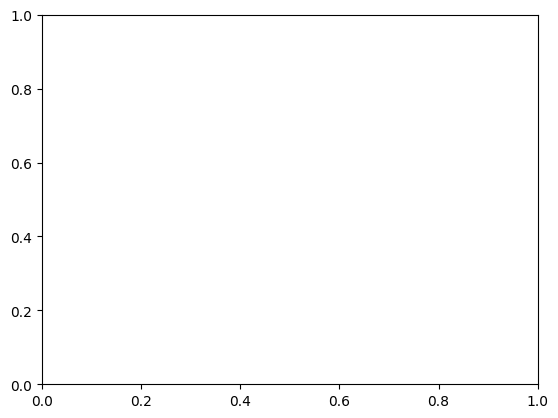

In [41]:
dfSource.boxplot(column=['price'],vert=False)

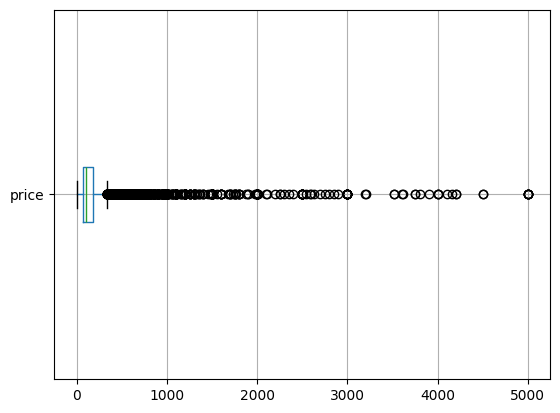

In [ ]:
dfSource=removeOutliersByThresholdValue(dfSource,'price',threshold_value=5000,draw_plot=True)

<h4>Check for Outlier: minimum_nights</h4>

<Axes: >

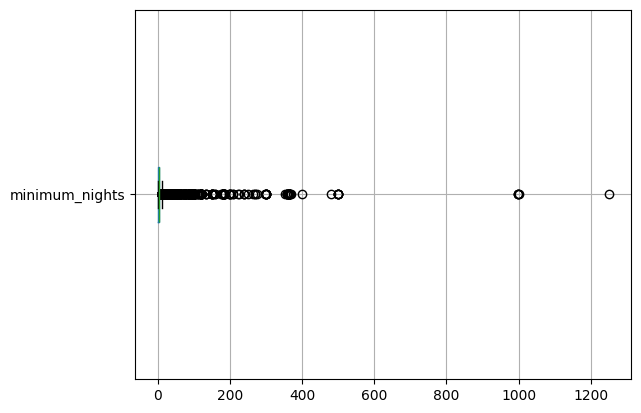

In [ ]:
dfSource.boxplot(column='minimum_nights',vert=False)

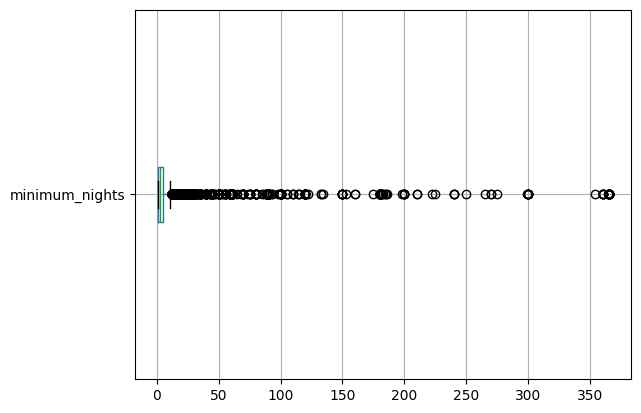

In [ ]:
#Removing minimum_nights above 365 considering a host may demand minimum 1 Year as max limit
dfSource=removeOutliersByThresholdValue(dfSource,'minimum_nights',threshold_value=365,draw_plot=True)




<h4>Check for Outlier: reviews_per_month</h4>

<Axes: >

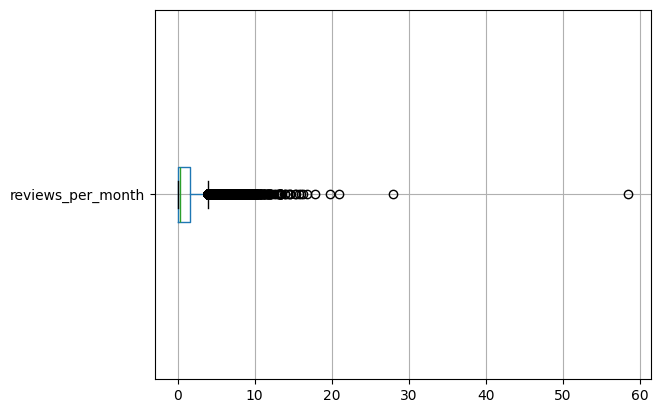

In [ ]:
dfSource.boxplot(column='reviews_per_month',vert=False)

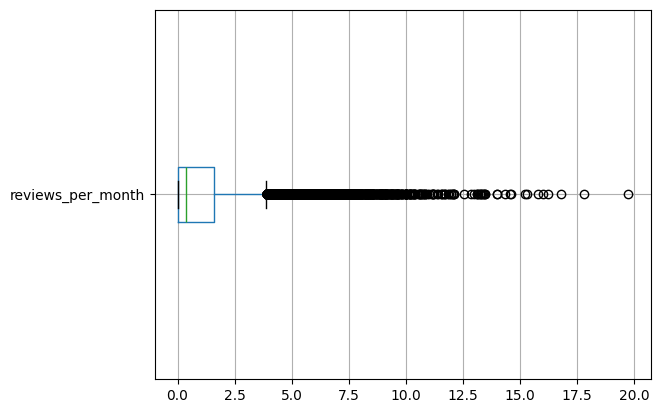

In [ ]:
dfSource=removeOutliersByThresholdValue(dfSource,'reviews_per_month',threshold_value=20,draw_plot=True)


<h4>Check for Outlier: number_of_reviews</h4>


<Axes: >

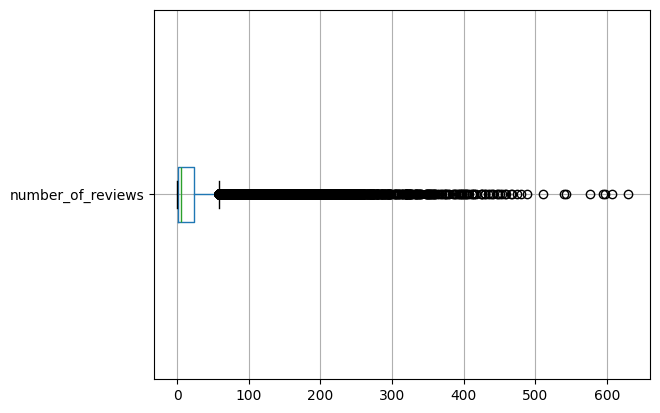

In [ ]:
dfSource.boxplot(column='number_of_reviews',vert=False)


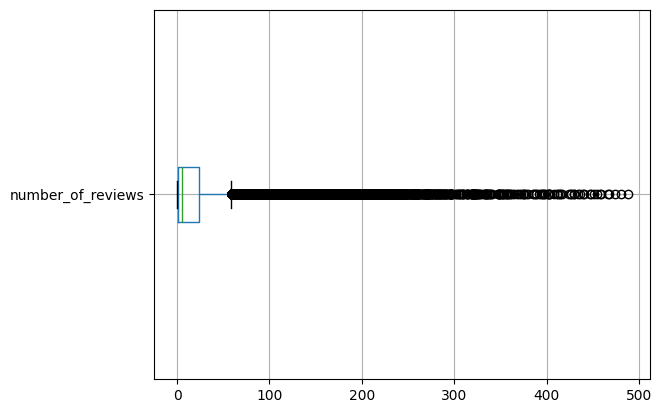

In [ ]:
dfSource=removeOutliersByThresholdValue(dfSource,'number_of_reviews',threshold_value=500,draw_plot=True)


<h4>Check for Outlier: calculated_host_listings_count</h4>


<Axes: >

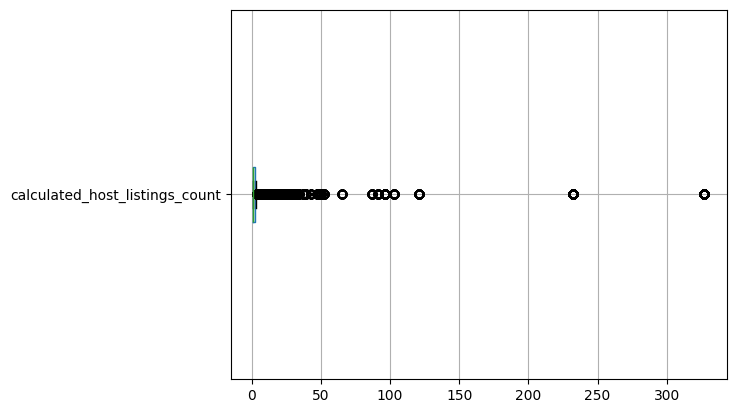

In [ ]:
dfSource.boxplot(column='calculated_host_listings_count',vert=False)


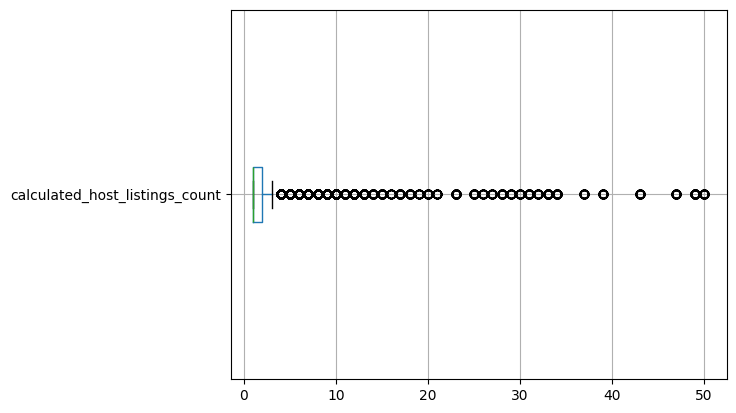

In [ ]:
dfSource=removeOutliersByThresholdValue(dfSource,'calculated_host_listings_count',threshold_value=50,draw_plot=True)


<h4>Check for Outlier: availability_365</h4>


In [ ]:
#dfSource.boxplot(column='availability_365',vert=False)
#looks okay no outliers


<h4> Add Additional Columns - for Grouping</h4>

In [ ]:
createBinValues(dfSource,'price',300,_StopMaxValue=1200)
createBinValues(dfSource,'availability_365',100)
createBinValues(dfSource,'reviews_per_month',2,_StopMaxValue=8)
createBinValues(dfSource,'minimum_nights',29,_StopMaxValue=30)
createBinValues(dfSource,'number_of_reviews',60,_StopMaxValue=120)

dfSource.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,availability_365,last_review_date,last_review_Year,last_review_month,last_review_elapsed,pricegroup,availability_365group,reviews_per_monthgroup,minimum_nightsgroup,number_of_reviewsgroup
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,365,2018-10-19,2018,10,2333.0,0-300,300-400,0-2,1-30,0-60
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,355,2019-05-21,2019,05,2119.0,0-300,300-400,0-2,1-30,0-60
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,365,NaT,NaN,NaN,0.0,0-300,300-400,0-2,1-30,0-60
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,194,2019-07-05,2019,07,2074.0,0-300,100-200,2-4,1-30,Greater Than 120
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,0,2018-11-19,2018,11,2302.0,0-300,0-100,0-2,1-30,0-60


<h4>Extract Feature Information from listing Name like : Bedrooms and check for additional Features like Furnished etc., </h4>

In [ ]:
words_to_numbers={
    'one':1,
    'two':2,
    'three':3,
    'four':4,
    'five':5,
    'six':6,
    'seven':7,
    'eight':8,
    'nine':9,
    'ten':10,
    'zero':0
}
list(words_to_numbers.keys())

['one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine',
 'ten',
 'zero']

In [ ]:
import re
dfSource['Bedroom']=''
dfSource['Bedroom_Matched']=0
words_to_numbers={
    'one':1,
    'two':2,
    'three':3,
    'four':4,
    'five':5,
    'six':6,
    'seven':7,
    'eight':8,
    'nine':9,
    'ten':10,
    'zero':0
}
rowIndex=0
_listSource=list(dfSource['name'].unique())
for _currentstr in _listSource:
    try:
        listOfStrings=[" br ","bedroom","bdrm","bed room","br","bed"]
        _matchString=_currentstr.lower()
        _matchString=re.sub('[^a-zA-Z0-9 \n\.]',' ',_matchString)
        matchExists=any(substring in _currentstr.lower() for substring in listOfStrings)
        if matchExists==True:
            dfSource.at[rowIndex,"Bedroom_Matched"]=1
            _tokens=_matchString.split(" ")
            _columnIndex=0
            for _token in _tokens:
                result=re.search(r"(^[0-9].*br$)|(^[0-9]{1}.*br$)|(.*bedroom*)|(.*bdrm*)",_token,re.IGNORECASE)
                if result!=None:
                    _prev=_tokens[_columnIndex-1].lower()
                    _bedroomNumber=''
                    if _prev.isdigit():
                        _bedroomNumber=_prev
                    if _prev in list(words_to_numbers.keys()):
                        _bedroomNUmber=words_to_numbers[_prev]
                    if _bedroomNumber=='':
                        _bedroomNumber='1'
                    if _bedroomNumber!='':
                        dfSource.at[rowIndex,"Bedroom"]=_bedroomNumber
                _columnIndex=_columnIndex+1
    except:
        continue
    rowIndex=rowIndex+1



In [ ]:
dfSource['Bedroom'].value_counts()

Bedroom
      36837
1      9063
2      1363
3       442
4        91
5        23
6        10
7         4
14        1
8         1
01        1
Name: count, dtype: int64

In [ ]:
dfSource['name']=dfSource['name'].astype(str)
dfSource['Furnished']=dfSource['name'].apply(lambda x: 1 if 'furn' in x.lower() else 0)
dfSource['Has_Gym']=dfSource['name'].apply(lambda x: 1 if 'gym' in x.lower() else 0)
dfSource['Gender_Spec']=dfSource['name'].apply(lambda x: 1 if any(substring in x.lower() for substring in ['guys','male','female','woman']) else 0)
dfSource['Landmark_Spec']=dfSource['name'].apply(lambda x: 1 if any(substring in x.lower() for substring in ['near','stop','mins','minute','from']) else 0)
dfSource['Event_Spec']=dfSource['name'].apply(lambda x: 1 if any(substring in x.lower() for substring in ['superbowl','super bowl']) else 0)
dfSource['Bedroom_Spec']=dfSource['Bedroom'].apply(lambda x: 1 if x!='' else 0)

In [ ]:
dfSource.to_csv('AB_NYC_Analysed.csv',index=False)

In [ ]:
getColumnsByType(dfSource,'numeric')

['id',
 'host_id',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'last_review_elapsed',
 'Bedroom_Matched',
 'Furnished',
 'Has_Gym',
 'Gender_Spec',
 'Landmark_Spec',
 'Event_Spec',
 'Bedroom_Spec']

In [ ]:
numeric_columns=['price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'last_review_elapsed',
 'Bedroom_Spec',
 'Furnished',
 'Has_Gym',
 'Gender_Spec',
 'Landmark_Spec',
 'Event_Spec',
 'Bedroom_Spec']

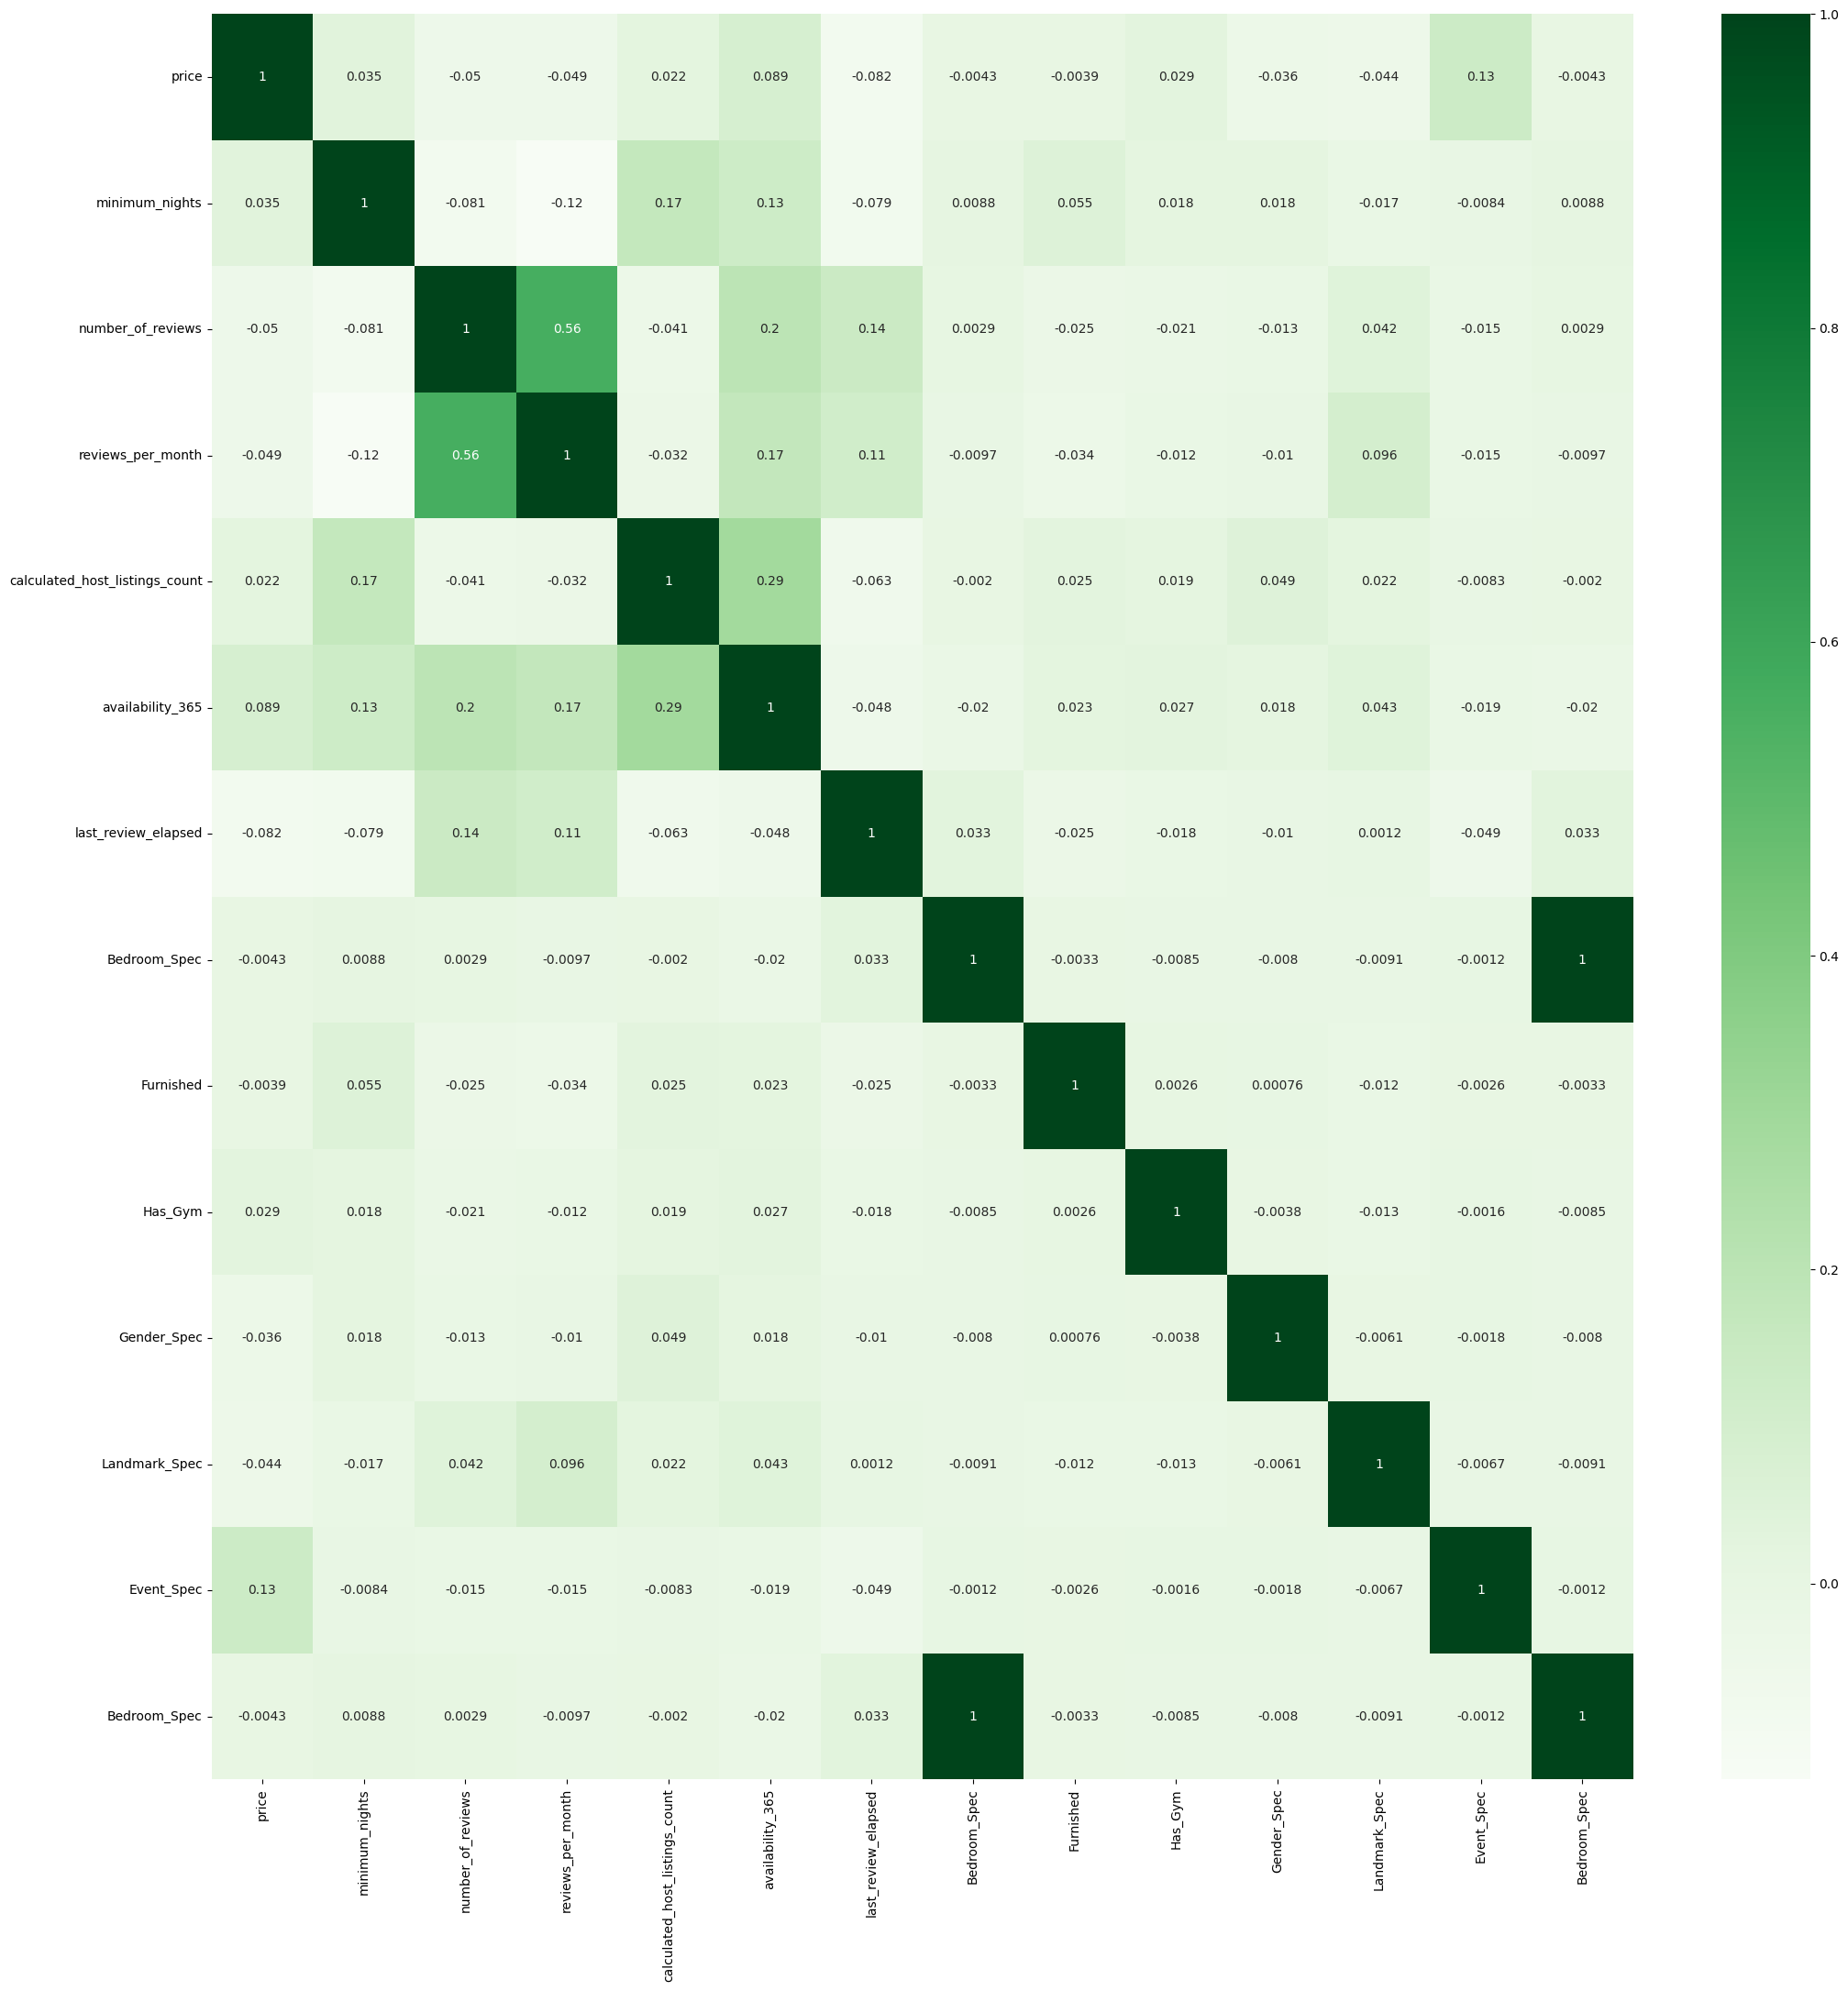

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(dfSource[numeric_columns].corr(),annot=True,cmap='Greens')
plt.show()

In [ ]:
dfSource_Numeric=dfSource[numeric_columns]
dfSource_Numeric.fillna(0,inplace=True)
dfSource_Numeric

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_elapsed,Bedroom_Spec,Furnished,Has_Gym,Gender_Spec,Landmark_Spec,Event_Spec,Bedroom_Spec
0,149.0,1.0,9.0,0.0,6.0,365.0,2333.0,0,0,0,0,0,0,0
1,225.0,1.0,45.0,0.0,2.0,355.0,2119.0,0,0,0,0,0,0,0
2,150.0,3.0,0.0,0.0,1.0,365.0,0.0,0,0,0,0,0,0,0
3,89.0,1.0,270.0,4.0,1.0,194.0,2074.0,0,0,0,0,0,0,0
4,80.0,10.0,9.0,0.0,1.0,0.0,2302.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1
45953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1
45955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1
45959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1


In [ ]:
dfSource_Numeric.shape

(48080, 14)

In [ ]:
type(dfSource_Numeric)

pandas.core.frame.DataFrame

In [ ]:
# plt.figure(figsize=(10,10))
# sns.pairplot(data=dfSource[['price',
#  'minimum_nights',
#  'number_of_reviews',
#  'reviews_per_month',
#  'calculated_host_listings_count',
#  'availability_365',
#  'last_review_elapsed',
#  'Furnished',
#  'Has_Gym',
#  'Gender_Spec',
#  'Landmark_Spec',
#  'Event_Spec',
#  'Bedroom_Spec']])
# plt.show()


<h3>Creating Dummy Variables</h3>

In [ ]:
dfSource.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'last_review_date', 'last_review_Year',
       'last_review_month', 'last_review_elapsed', 'pricegroup',
       'availability_365group', 'reviews_per_monthgroup',
       'minimum_nightsgroup', 'number_of_reviewsgroup', 'Bedroom',
       'Bedroom_Matched', 'Furnished', 'Has_Gym', 'Gender_Spec',
       'Landmark_Spec', 'Event_Spec', 'Bedroom_Spec'],
      dtype='object')

In [ ]:
price_group_dummy=pd.get_dummies(dfSource['pricegroup'],prefix='price',drop_first=True)
price_group_dummy.head()


,price_300-600,price_600-900,price_900-1200,price_Greater Than 1200
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


In [ ]:
room_type_dummy=pd.get_dummies(dfSource['room_type'],drop_first=True)
room_type_dummy.head()


,Private room,Shared room
0,True,False
1,False,False
2,True,False
3,False,False
4,False,False


In [ ]:
neighbourhood_group_dummy=pd.get_dummies(dfSource['neighbourhood_group'],drop_first=True)
neighbourhood_group_dummy.head()


,Brooklyn,Manhattan,Queens,Staten Island
0,True,False,False,False
1,False,True,False,False
2,False,True,False,False
3,True,False,False,False
4,False,True,False,False


In [ ]:
availability_365group_dummy=pd.get_dummies(dfSource['availability_365group'],drop_first=True,prefix='AVL_365')
availability_365group_dummy.head()


,AVL_365_100-200,AVL_365_200-300,AVL_365_300-400
0,False,False,True
1,False,False,True
2,False,False,True
3,True,False,False
4,False,False,False


In [ ]:
reviews_per_monthgroup_dummy=pd.get_dummies(dfSource['reviews_per_monthgroup'],drop_first=True,prefix='RVWSPERMONTH')
minimum_nightsgroup_dummy=pd.get_dummies(dfSource['minimum_nightsgroup'],drop_first=True,prefix='MIN_NTS')
number_of_reviewsgroup_dummy=pd.get_dummies(dfSource['number_of_reviewsgroup'],drop_first=True,prefix='NUM_RVW')

In [ ]:
reviews_per_monthgroup_dummy.head()

,RVWSPERMONTH_2-4,RVWSPERMONTH_4-6,RVWSPERMONTH_6-8,RVWSPERMONTH_Greater Than 8
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,True,False,False,False
4,False,False,False,False


In [ ]:
minimum_nightsgroup_dummy.head()

,MIN_NTS_Greater Than 30
0,False
1,False
2,False
3,False
4,False


In [ ]:
number_of_reviewsgroup_dummy.head()

,NUM_RVW_60-120,NUM_RVW_Greater Than 120
0,False,False
1,False,False
2,False,False
3,False,True
4,False,False


In [ ]:
dfSource=pd.concat([dfSource,price_group_dummy],axis=1)
dfSource=pd.concat([dfSource,room_type_dummy],axis=1)
dfSource=pd.concat([dfSource,neighbourhood_group_dummy],axis=1)
dfSource=pd.concat([dfSource,availability_365group_dummy],axis=1)
dfSource=pd.concat([dfSource,reviews_per_monthgroup_dummy],axis=1)
dfSource=pd.concat([dfSource,minimum_nightsgroup_dummy],axis=1)
dfSource=pd.concat([dfSource,number_of_reviewsgroup_dummy],axis=1)

In [ ]:
dfSource_Analysis=dfSource.copy(deep=True)
dfSource_Analysis.columns


Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'last_review_date', 'last_review_Year',
       'last_review_month', 'last_review_elapsed', 'pricegroup',
       'availability_365group', 'reviews_per_monthgroup',
       'minimum_nightsgroup', 'number_of_reviewsgroup', 'Bedroom',
       'Bedroom_Matched', 'Furnished', 'Has_Gym', 'Gender_Spec',
       'Landmark_Spec', 'Event_Spec', 'Bedroom_Spec', 'price_300-600',
       'price_600-900', 'price_900-1200', 'price_Greater Than 1200',
       'Private room', 'Shared room', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten Island', 'AVL_365_100-200', 'AVL_365_200-300',
       'AVL_365_300-400', 'RVWSPERMONTH_2-4', 'RVWSPERMONTH_4-6',
       'RVWSPERMONTH_6-8', 'RVWSPERMONTH_Greater Than 8',
       'MIN_NTS_G

In [ ]:
getColumnsByType(dfSource_Analysis,'categorical')

['name',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'room_type',
 'last_review',
 'last_review_Year',
 'last_review_month',
 'pricegroup',
 'availability_365group',
 'reviews_per_monthgroup',
 'minimum_nightsgroup',
 'number_of_reviewsgroup',
 'Bedroom']

In [ ]:
dfSource_Analysis.drop(['name',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'room_type',
 'last_review',
 'last_review_Year',
 'last_review_month',
 'pricegroup',
 'availability_365group',
 'reviews_per_monthgroup',
 'minimum_nightsgroup',
 'number_of_reviewsgroup',
 'Bedroom'],axis=1,inplace=True)

In [ ]:
dfSource_Analysis.dtypes

id                                       float64
host_id                                  float64
latitude                                 float64
longitude                                float64
price                                    float64
minimum_nights                           float64
number_of_reviews                        float64
reviews_per_month                        float64
calculated_host_listings_count           float64
availability_365                         float64
last_review_date                  datetime64[ns]
last_review_elapsed                      float64
Bedroom_Matched                          float64
Furnished                                  int64
Has_Gym                                    int64
Gender_Spec                                int64
Landmark_Spec                              int64
Event_Spec                                 int64
Bedroom_Spec                               int64
price_300-600                               bool
price_600-900       

In [ ]:
getColumnsByType(dfSource_Analysis,'numeric')

['id',
 'host_id',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'last_review_elapsed',
 'Bedroom_Matched',
 'Furnished',
 'Has_Gym',
 'Gender_Spec',
 'Landmark_Spec',
 'Event_Spec',
 'Bedroom_Spec',
 'price_300-600',
 'price_600-900',
 'price_900-1200',
 'price_Greater Than 1200',
 'Private room',
 'Shared room',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'AVL_365_100-200',
 'AVL_365_200-300',
 'AVL_365_300-400',
 'RVWSPERMONTH_2-4',
 'RVWSPERMONTH_4-6',
 'RVWSPERMONTH_6-8',
 'RVWSPERMONTH_Greater Than 8',
 'MIN_NTS_Greater Than 30',
 'NUM_RVW_60-120',
 'NUM_RVW_Greater Than 120']

In [ ]:
dfSource_Analysis.drop(
['id',
 'host_id',
 'latitude',
 'longitude',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'availability_365',
 'last_review_elapsed',
 'Bedroom_Matched',
 'last_review_date',
 'Furnished',
 'Has_Gym',
 'Gender_Spec',
 'Landmark_Spec',
 'Event_Spec',
 'Bedroom_Spec',
 'calculated_host_listings_count'
]
,axis=1,inplace=True,errors='ignore')

In [ ]:
dfSource_Analysis.dtypes

price                          float64
price_300-600                     bool
price_600-900                     bool
price_900-1200                    bool
price_Greater Than 1200           bool
Private room                      bool
Shared room                       bool
Brooklyn                          bool
Manhattan                         bool
Queens                            bool
Staten Island                     bool
AVL_365_100-200                   bool
AVL_365_200-300                   bool
AVL_365_300-400                   bool
RVWSPERMONTH_2-4                  bool
RVWSPERMONTH_4-6                  bool
RVWSPERMONTH_6-8                  bool
RVWSPERMONTH_Greater Than 8       bool
MIN_NTS_Greater Than 30           bool
NUM_RVW_60-120                    bool
NUM_RVW_Greater Than 120          bool
dtype: object

<h4>Building a Linear MOdel</h4>

In [ ]:
dfSource_Analysis=dfSource_Analysis.astype(float)
dfSource_Analysis.fillna(0,inplace=True)

from sklearn.model_selection import train_test_split
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
dfSource_Analysis_train_rfe, dfSource_Analysis_test_rfe = train_test_split(dfSource_Analysis, train_size = 0.7, test_size = 0.3, random_state = 100)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
numerical_variables=getColumnsByType(dfSource_Analysis,'numeric')
nFeatures=len(numerical_variables)
dfSource_Analysis_train_rfe[numerical_variables] = scaler.fit_transform(dfSource_Analysis_train_rfe[numerical_variables])
dfSource_Analysis_train_rfe.head()

,price,price_300-600,price_600-900,price_900-1200,price_Greater Than 1200,Private room,Shared room,Brooklyn,Manhattan,Queens,...,AVL_365_100-200,AVL_365_200-300,AVL_365_300-400,RVWSPERMONTH_2-4,RVWSPERMONTH_4-6,RVWSPERMONTH_6-8,RVWSPERMONTH_Greater Than 8,MIN_NTS_Greater Than 30,NUM_RVW_60-120,NUM_RVW_Greater Than 120
28062,0.0666,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44735,0.0380,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35697,0.0056,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13214,0.0500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14192,0.0396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4>Dividing into X and Y sets for model building</h4>

In [ ]:
y_train_new = dfSource_Analysis_train_rfe.pop('price')
X_train_new = dfSource_Analysis_train_rfe

<h4>Building Model Using RFE</h4>

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [ ]:
lm = LinearRegression()
lm.fit(X_train_new, y_train_new)

rfe = RFE(lm, n_features_to_select=nFeatures)             # running RFE
rfe = rfe.fit(X_train_new, y_train_new)

In [ ]:
list(zip(X_train_new.columns,rfe.support_,rfe.ranking_))


[('price_300-600', True, 1),
 ('price_600-900', True, 1),
 ('price_900-1200', True, 1),
 ('price_Greater Than 1200', True, 1),
 ('Private room', True, 1),
 ('Shared room', True, 1),
 ('Brooklyn', True, 1),
 ('Manhattan', True, 1),
 ('Queens', True, 1),
 ('Staten Island', True, 1),
 ('AVL_365_100-200', True, 1),
 ('AVL_365_200-300', True, 1),
 ('AVL_365_300-400', True, 1),
 ('RVWSPERMONTH_2-4', True, 1),
 ('RVWSPERMONTH_4-6', True, 1),
 ('RVWSPERMONTH_6-8', True, 1),
 ('RVWSPERMONTH_Greater Than 8', True, 1),
 ('MIN_NTS_Greater Than 30', True, 1),
 ('NUM_RVW_60-120', True, 1),
 ('NUM_RVW_Greater Than 120', True, 1)]

In [ ]:
col = X_train_new.columns[rfe.support_]
col

Index(['price_300-600', 'price_600-900', 'price_900-1200',
       'price_Greater Than 1200', 'Private room', 'Shared room', 'Brooklyn',
       'Manhattan', 'Queens', 'Staten Island', 'AVL_365_100-200',
       'AVL_365_200-300', 'AVL_365_300-400', 'RVWSPERMONTH_2-4',
       'RVWSPERMONTH_4-6', 'RVWSPERMONTH_6-8', 'RVWSPERMONTH_Greater Than 8',
       'MIN_NTS_Greater Than 30', 'NUM_RVW_60-120',
       'NUM_RVW_Greater Than 120'],
      dtype='object')

In [ ]:
X_train_rfe = X_train_new[col]

In [ ]:
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)


In [ ]:
def getModelTable1AsDataFrames(lr_RFE_1):
    dfTable1=pd.DataFrame(lr_RFE_1.summary().tables[0].data).transpose()
    dfPart1=dfTable1.iloc[0:2]
    dfPart2=dfTable1.iloc[2:]
    dfPart1.columns=list(dfPart1.iloc[0])
    dfPart1.drop(dfPart1.index[0],axis=0,inplace=True)
    dfPart1=dfPart1.reset_index(drop=True)
    dfPart1.columns = dfPart1.columns.str.strip()

    dfPart2=dfTable1.iloc[2:]
    dfPart2.columns=list(dfPart2.iloc[0])
    dfPart2.drop(dfPart2.index[0],axis=0,inplace=True)

    dfPart2=dfPart2.reset_index(drop=True)
    dfPart2.columns = dfPart2.columns.str.strip()
    _selectedColumns=[]
    for _col in dfPart2.columns:
        #print(_col,_col=="")
        if _col!="":
            _selectedColumns.append(_col)
    dfPart2=dfPart2[_selectedColumns] 
    return pd.concat([dfPart1,dfPart2],axis=1)

In [ ]:
def getModelSummaryAsDataFrame(lr_RFE_1,showstats=True):
    results_df = pd.DataFrame(lr_RFE_1.summary().tables[1].data)
    results_df = results_df.set_index(0)
    #print(list(results_df.iloc[0]))
    _lstCols=[]
    for item in results_df.iloc[0]:
        #print("item",str(item))
        _lstCols.append(str(item))
    results_df.columns = _lstCols
    results_df = results_df.iloc[1:]
    results_df.index.name='Parameter'
    results_df.rename(columns={'P>|t|':'pvalues'},inplace=True)
    results_df=results_df.reset_index()
    results_df['pvalues']=results_df['pvalues'].astype(float)
    if showstats==True:
        df1=getModelTable1AsDataFrames(lr_RFE_1)
        for _col in df1.columns:
            results_df[_col]=df1[_col]
    return results_df

In [ ]:
def getInsignificantColumn(model_variable,pvalue_threshold=0.05,showstats=False):
    df=getModelSummaryAsDataFrame(model_variable,showstats)
    return df[df['pvalues']>pvalue_threshold].sort_values(by='pvalues',ascending=False,)

In [ ]:
lr_RFE_1 = sm.OLS(y_train_new,X_train_rfe).fit()   # Running the linear model

In [ ]:
getModelTable1AsDataFrames(lr_RFE_1)

,Dep. Variable:,Model:,Method:,Date:,Time:,No. Observations:,Df Residuals:,Df Model:,Covariance Type:,R-squared:,Adj. R-squared:,F-statistic:,Prob (F-statistic):,Log-Likelihood:,AIC:,BIC:
0,price,OLS,Least Squares,"Sun, 09 Mar 2025",13:13:47,33656,33635,20,nonrobust,0.833,0.833,8368.,0.00,93418.,-1.868e+05,-1.866e+05


In [ ]:
getInsignificantColumn(lr_RFE_1)

,Parameter,coef,std err,t,pvalues,[0.025,0.975]
16,RVWSPERMONTH_6-8,0.0001,0.001,0.116,0.908,-0.002,0.002
15,RVWSPERMONTH_4-6,-0.0002,0.001,-0.365,0.715,-0.001,0.001
14,RVWSPERMONTH_2-4,-0.0004,0.000,-1.258,0.208,-0.001,0.000
18,MIN_NTS_Greater Than 30,-0.0013,0.001,-1.872,0.061,-0.003,5.97e-05


In [ ]:
removed_columns_RFE=[]

In [ ]:
_column_current='RVWSPERMONTH_6-8'
removed_columns_RFE.append(_column_current)
X_train_rfe.drop(_column_current, axis = 1,inplace=True)
X_train_lm_new = sm.add_constant(X_train_rfe)
lr_RFE_2=sm.OLS(y_train_new,X_train_lm_new).fit()
getInsignificantColumn(lr_RFE_2)

,Parameter,coef,std err,t,pvalues,[0.025,0.975]
15,RVWSPERMONTH_4-6,-0.0002,0.001,-0.370,0.712,-0.001,0.001
14,RVWSPERMONTH_2-4,-0.0004,0.000,-1.269,0.205,-0.001,0.000
17,MIN_NTS_Greater Than 30,-0.0013,0.001,-1.874,0.061,-0.003,5.88e-05


In [ ]:
_column_current='RVWSPERMONTH_4-6'
removed_columns_RFE.append(_column_current)
X_train_rfe.drop(_column_current, axis = 1,inplace=True)
X_train_lm_new = sm.add_constant(X_train_rfe)
lr_RFE_3=sm.OLS(y_train_new,X_train_lm_new).fit()
getInsignificantColumn(lr_RFE_3)

,Parameter,coef,std err,t,pvalues,[0.025,0.975]
14,RVWSPERMONTH_2-4,-0.0004,0.000,-1.233,0.218,-0.001,0.000
16,MIN_NTS_Greater Than 30,-0.0013,0.001,-1.868,0.062,-0.003,6.25e-05


In [ ]:
_column_current='RVWSPERMONTH_2-4'
removed_columns_RFE.append(_column_current)
X_train_rfe.drop(_column_current, axis = 1,inplace=True)
X_train_lm_new = sm.add_constant(X_train_rfe)
lr_RFE_4=sm.OLS(y_train_new,X_train_lm_new).fit()
getInsignificantColumn(lr_RFE_4)

,Parameter,coef,std err,t,pvalues,[0.025,0.975]
15,MIN_NTS_Greater Than 30,-0.0012,0.001,-1.835,0.066,-0.003,8.49e-05


In [ ]:
_column_current='MIN_NTS_Greater Than 30'
removed_columns_RFE.append(_column_current)
X_train_rfe.drop(_column_current, axis = 1,inplace=True)
X_train_lm_new = sm.add_constant(X_train_rfe)
lr_RFE_5=sm.OLS(y_train_new,X_train_lm_new).fit()
getInsignificantColumn(lr_RFE_5)

,Parameter,coef,std err,t,pvalues,[0.025,0.975]


In [ ]:
def getVIF(X_train_rfe,threshold=5):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif = pd.DataFrame()
    X_new = X_train_rfe
    vif['Features'] = X_new.columns
    vif['VIF'] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif['Outside Limit?']=vif['VIF']>5
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif[vif['VIF']>=threshold]
    

In [ ]:
getVIF(X_train_rfe)

,Features,VIF,Outside Limit?
0,const,30.88,True
8,Manhattan,7.81,True
7,Brooklyn,7.78,True


In [ ]:
_column_current='const'
removed_columns_RFE.append(_column_current)
X_train_rfe.drop(_column_current, axis = 1,inplace=True)
X_train_lm_new = sm.add_constant(X_train_rfe)
lr_RFE_6=sm.OLS(y_train_new,X_train_lm_new).fit()
getInsignificantColumn(lr_RFE_6)

,Parameter,coef,std err,t,pvalues,[0.025,0.975]


In [ ]:
getVIF(X_train_rfe)

,Features,VIF,Outside Limit?


In [ ]:
y_train_cnt_new = lr_RFE_6.predict(X_train_lm_new)

Text(0.5, 0, 'Errors')

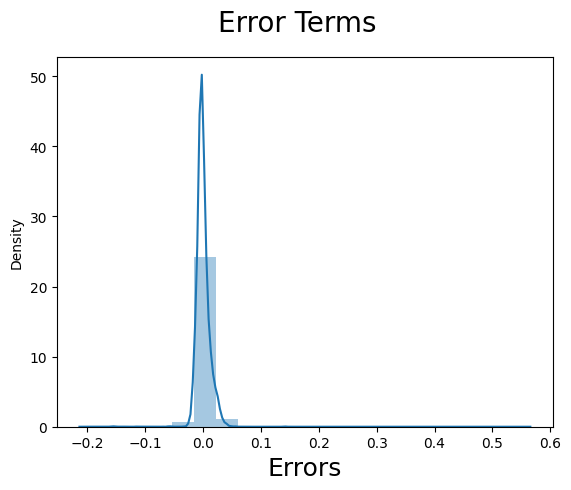

In [ ]:
fig = plt.figure()
sns.distplot((y_train_new - y_train_cnt_new), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [ ]:
numerical_variables=getColumnsByType(dfSource_Analysis_test_rfe,'numeric')
numerical_variables

['price',
 'price_300-600',
 'price_600-900',
 'price_900-1200',
 'price_Greater Than 1200',
 'Private room',
 'Shared room',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'AVL_365_100-200',
 'AVL_365_200-300',
 'AVL_365_300-400',
 'RVWSPERMONTH_2-4',
 'RVWSPERMONTH_4-6',
 'RVWSPERMONTH_6-8',
 'RVWSPERMONTH_Greater Than 8',
 'MIN_NTS_Greater Than 30',
 'NUM_RVW_60-120',
 'NUM_RVW_Greater Than 120']

In [ ]:
dfSource_Analysis_test_rfe [numerical_variables] = scaler.transform(dfSource_Analysis_test_rfe[numerical_variables])

In [ ]:
y_test_new = dfSource_Analysis_test_rfe.pop('price')
X_test_new = dfSource_Analysis_test_rfe

In [ ]:
X_test_new = X_test_new[X_train_rfe.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [ ]:
y_pred_cnt_new = lr_RFE_6.predict(X_test_new)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test_new, y_pred_cnt_new)

0.8059996807702011

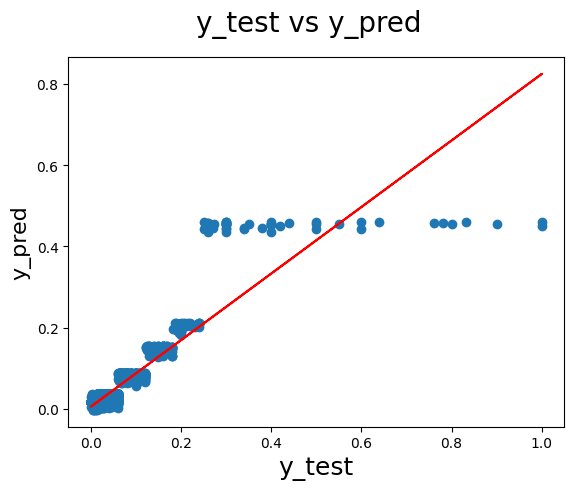

In [ ]:
fig = plt.figure()
plt.scatter(y_test_new,y_pred_cnt_new)
m, b= np.polyfit(y_test_new, y_pred_cnt_new,1)

fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

plt.plot(y_test_new, m*y_test_new+b, color='red') 

In [ ]:
df=getModelSummaryAsDataFrame(lr_RFE_6,False)
df["eqn_variable"]=df["Parameter"].str.strip()+" x "+ df["coef"].str.strip()
' + '.join(list(df["eqn_variable"].unique()))



'const x 0.0158 + price_300-600 x 0.0511 + price_600-900 x 0.1169 + price_900-1200 x 0.1741 + price_Greater Than 1200 x 0.4225 + Private room x -0.0142 + Shared room x -0.0185 + Brooklyn x 0.0123 + Manhattan x 0.0178 + Queens x 0.0100 + Staten Island x 0.0090 + AVL_365_100-200 x 0.0021 + AVL_365_200-300 x 0.0020 + AVL_365_300-400 x 0.0037 + RVWSPERMONTH_Greater Than 8 x -0.0031 + NUM_RVW_60-120 x -0.0007 + NUM_RVW_Greater Than 120 x -0.0012'

In [ ]:
lr_RFE_6.Summary()

NameError: name 'lr_RFE_6' is not defined